# Практическая работа №2
## по предмету "Системы искусственного интеллекта"
### БВТ2101 Юдин Артём

Целью практической работы является изучение моделей машинного обучения для задачи регрессии.

Выполните предварительную обработку и анализ набора данных.

Затем вам необходимо выбрать 3 модели машинного обучения, которые могут решать задачу регрессии, и обучить их на основе данного набора данных. Обязательным условием является построение графика изменения loss для каждой из выбранных моделей. В результате выполнения работы необходимо сделать вывод, какая из моделей лучше подошла для решения поставленной задачи.

In [80]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error as rmse

import catboost as cb

import warnings
warnings.simplefilter("ignore")

In [4]:
df = pl.read_csv("../csv/AISP2.csv")
df.sample(10)

brand,processor_brand,processor_name,processor_gnrtn,ram_gb,ram_type,ssd,hdd,os,os_bit,graphic_card_gb,weight,warranty,Touchscreen,msoffice,Price,rating,Number of Ratings,Number of Reviews
str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,str,i64,i64
"""HP""","""Intel""","""Core i5""","""11th""","""8 GB""","""DDR4""","""512 GB""","""0 GB""","""Windows""","""64-bit""","""0 GB""","""ThinNlight""","""1 year""","""No""","""Yes""",61000,"""4 stars""",1124,100
"""ASUS""","""AMD""","""Ryzen 3""","""Not Available""","""4 GB""","""DDR4""","""256 GB""","""0 GB""","""Windows""","""64-bit""","""0 GB""","""ThinNlight""","""1 year""","""No""","""No""",33690,"""4 stars""",170,26
"""Lenovo""","""Intel""","""Core i3""","""10th""","""8 GB""","""DDR4""","""256 GB""","""0 GB""","""Windows""","""32-bit""","""0 GB""","""Casual""","""No warranty""","""No""","""No""",38970,"""3 stars""",0,0
"""MSI""","""AMD""","""Ryzen 7""","""Not Available""","""4 GB""","""DDR4""","""512 GB""","""0 GB""","""Windows""","""64-bit""","""0 GB""","""Casual""","""No warranty""","""No""","""No""",64990,"""3 stars""",0,0
"""DELL""","""Intel""","""Core i5""","""11th""","""8 GB""","""DDR4""","""512 GB""","""0 GB""","""Windows""","""64-bit""","""2 GB""","""Casual""","""1 year""","""No""","""Yes""",70980,"""4 stars""",138,23
"""ASUS""","""Intel""","""Core i5""","""11th""","""8 GB""","""DDR4""","""512 GB""","""0 GB""","""Windows""","""64-bit""","""0 GB""","""Casual""","""1 year""","""No""","""Yes""",53190,"""4 stars""",11,0
"""acer""","""Intel""","""Core i5""","""8th""","""8 GB""","""DDR4""","""0 GB""","""1024 GB""","""Windows""","""64-bit""","""2 GB""","""Casual""","""1 year""","""No""","""Yes""",59999,"""4 stars""",118,28
"""ASUS""","""Intel""","""Core i9""","""11th""","""16 GB""","""DDR4""","""1024 GB""","""0 GB""","""Windows""","""64-bit""","""6 GB""","""Gaming""","""1 year""","""No""","""No""",139990,"""3 stars""",0,0
"""MSI""","""Intel""","""Core i5""","""11th""","""8 GB""","""DDR4""","""512 GB""","""0 GB""","""Windows""","""64-bit""","""4 GB""","""Casual""","""No warranty""","""No""","""No""",74990,"""3 stars""",0,0


Линейно зависимые признаки могут повредить линейным моделям

+ Drop number of reviews
+ Drop processor brand

In [5]:
df.select(pl.corr("Number of Ratings", "Number of Reviews"))

Number of Ratings
f64
0.989626


In [6]:
df = df.drop(["Number of Reviews", "processor_brand"])

In [7]:
cat_cols = [
    "brand",
    'processor_name',
    'processor_gnrtn',
    'ram_gb',
    'ram_type',
    'ssd',
    'hdd',
    'os',
    'os_bit',
    'graphic_card_gb',
    'weight',
    'warranty',
    'Touchscreen',
    'msoffice',
    'rating'
]

num_cols = ['Number of Ratings']
target_col = ['Price']

In [78]:
class RidgeRegression:
    def __init__(self, C: float = 1.):
        self.C = C
        self.w = None

    def regularization_term(self) -> np.ndarray:
        outp = 2 * self.w.copy()
        outp[0] = 0  # Не нужно регуляризовывать по свободному члену
        return outp

    def grad(self, X_train: np.ndarray, y_train:np.ndarray) -> np.ndarray:
        y_pred = (X_train @ self.w)  # [ell, 1]

        basic_term = 2. / X_train.shape[0] * (X_train.T @ (y_pred - y_train))

        regularization_term = self.regularization_term()


        return np.mean(basic_term, axis=0) + self.C * regularization_term


    def fit(self, 
            X_train: np.ndarray, 
            y_train: np.ndarray,
            X_test: np.ndarray,
            y_test: np.ndarray, 
            max_iter: int = 10, 
            lr: float = 0.1) -> list[np.float64]:
        assert X_train.shape[0] == y_train.shape[0], f"{X_train.shape}, {y_train.shape}"
        X_train = X_train.toarray()
        X_test = X_test.toarray()
        y_train = y_train[:, np.newaxis]
        

        if self.w is None:
            self.w = np.random.randn(X_train.shape[1], 1)

        losses = []

        for iter_num in range(max_iter):            
            grad = self.grad(X_train, y_train)
            self.w -= grad * lr / np.sqrt(iter_num + 1)

            loss = rmse(y_test, self.predict(X_test)) / 1.5
            losses.append(loss)
            
        return losses


    def predict(self, X_train: np.ndarray) -> np.ndarray:
        return X_train @ self.w

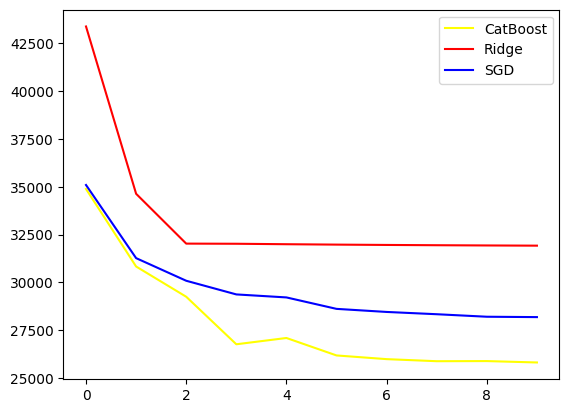

In [86]:
cat_trans = OneHotEncoder(handle_unknown="ignore", drop="first")
num_trans = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_trans, num_cols),
        ('cat2', cat_trans, cat_cols),
    ]
)


X = df.drop(target_col).to_pandas()
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y.to_numpy(),
                                                    shuffle=True,
                                                    test_size=0.2,
                                                    random_state=42)
cbr = cb.CatBoostRegressor(iterations=10,
                          learning_rate=1,
                          depth=10,
                          verbose=False)

cbr.fit(X_train, y_train, eval_set=(X_test, y_test), cat_features=cat_cols)



X = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y.to_numpy(),
                                                    shuffle=True,
                                                    test_size=0.2,
                                                    random_state=42)

sgd_loss = []
for i in range(10):
    model_regressor = SGDRegressor(max_iter=i+1, tol=1e-3, shuffle=True)
    idx = np.random.permutation(X_train.shape[0])
    X_train_epoch = X_train[idx]
    y_train_epoch = y_train[idx]
    model_regressor.fit(X_train_epoch, y_train_epoch)
    y_pred = model_regressor.predict(X_test)
    sgd_loss.append(rmse(y_pred=y_pred, y_true=y_test))


reg = RidgeRegression()
ridge_loss = reg.fit(X_train, y_train, X_test, y_test)


plt.plot(cbr.evals_result_["validation"]["RMSE"], color="yellow", label="CatBoost")
plt.plot(ridge_loss, color="red", label="Ridge")
plt.plot(sgd_loss, color="blue", label="SGD")
plt.legend()
plt.show()

In [2]:
orig = [1708, 610, 392, 257, 203, 155, 150, 148]
glass = [1044, 462, 325, 213, 118, 84, 79, 47]
grid = [1227, 503, 245, 185, 164, 93, 59, 47]
grid2 = [4, 4, 4, 2, 5, 5, 2, 5]

for or_, gl, gr, gr2 in zip(orig, glass, grid, grid2):
    print(f"Glass: {(or_ - gl)/or_:.3f}, grid1: {(or_ - gr)/or_:.3f}, grid2: {(or_ - gr2)/or_:.3f}")

Glass: 0.389, grid1: 0.282, grid2: 0.998
Glass: 0.243, grid1: 0.175, grid2: 0.993
Glass: 0.171, grid1: 0.375, grid2: 0.990
Glass: 0.171, grid1: 0.280, grid2: 0.992
Glass: 0.419, grid1: 0.192, grid2: 0.975
Glass: 0.458, grid1: 0.400, grid2: 0.968
Glass: 0.473, grid1: 0.607, grid2: 0.987
Glass: 0.682, grid1: 0.682, grid2: 0.966
